In [28]:
import scipy.io as io
import numpy as np
import pandas as pd
import seaborn as sns
import timeit
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [29]:
def pca_mle(X, y, fig = True):
    count = 0
    norm = []
    anom = []
    for i in y:
        if i == 0:
            norm.append(count)
        else:
            anom.append(count)
        count += 1
    
    pca = PCA(n_components='mle')
    X_new = pca.fit_transform(X)
    
    if fig:
        plt.plot(X_new[norm, 0], X_new[norm, 1], 'bo', label = 'Normal')
        plt.plot(X_new[anom, 0], X_new[anom, 1], 'r*', label = 'Anomaly')
        plt.legend()
        plt.show()

    return X_new, y

def cy(y):
    newy = y.copy()
    newy = newy.astype('int32')
    newy[np.argwhere(y == 1)] = -1
    newy[np.argwhere(y == 0)] = int(1)
    newy = newy.flatten()
    newy = newy.flatten()
    return newy

def limit_y(X, y, per):
    count = 0
    norm = []
    anom = []
    for i in y:
        if i == 0:
            norm.append(count)
        else:
            anom.append(count)
        count += 1
    rp = np.array(np.random.permutation(np.size(anom)))
    anom = np.array(anom)
    norm = np.array(norm)
    num = int((per/(1-per)) * len(norm))
    newy = np.concatenate((y[norm], y[anom[rp[0:num]]]))
    newX = np.concatenate((X[norm, :], X[anom[rp[0:num]], :]))
    return newX, newy

def print_stats(est_y, newy):
    compare = sum(est_y == newy)
    anom = np.argwhere(newy == -1);
    fanom = est_y[anom] == newy[anom];
    found = float(sum(fanom)) / np.size(anom) * 100;

    print('Accuracy:', float(compare) / np.size(newy) * 100)
    print('\nF1 Score:', F1Calc(est_y, newy))
    print('\nPercent Anomalies Found:', found)
    
def F1Calc(est_y, y):
    out = np.argwhere(y == -1)
    tp = sum(est_y[out] == y[out])
    anom = np.size(out);
    pos = sum((est_y == -1));
    rec = float(tp) / anom;
    try:
        prec = float(tp) / pos;
        F1 = (2 * prec * rec) / (prec + rec);
    except ZeroDivisionError:
        F1 = 0
    return F1

def calc_stats(acc, f1, p_anom, prec, est_y, ytest):
    compare = sum(est_y == ytest)
    anom = np.argwhere(ytest == -1);
    fanom = est_y[anom] == ytest[anom];
    anomm = np.argwhere(est_y == -1)
    found = float(sum(fanom)) / np.size(anom) * 100;
    try:
        precc = float(sum(fanom)) / np.size(anomm) * 100;
    except ZeroDivisionError:
        precc = 0
    

    acc[i] = float(compare) / np.size(ytest) * 100
    f1[i] = F1Calc(est_y, ytest)
    p_anom[i] = found
    prec[i] = precc
    return [acc, f1, p_anom, prec]

def plotvar(n_est, acc, p_anom, prec, f1, rtime, method, variable, showtime):
    plt.plot(n_est, acc,label = 'Accuracy')
    plt.plot(n_est, p_anom,label = 'Percent Anomalies')
    plt.plot(n_est, prec, label = 'Precision')
    plt.plot(n_est, f1*100, label = 'F1')
    ind = np.argmax(f1)
    plt.plot(n_est[ind],f1[ind]*100, '*', label = 'Highest F1 Score')
    plt.legend()
    plt.title(method)
    plt.xlabel(variable)
    plt.show()
    if showtime:
        plt.figure()
        plt.plot(n_est, rtime)
        plt.ylabel('Time (s)')
        plt.xlabel(variable)
        plt.title('Run Time')
        plt.show()

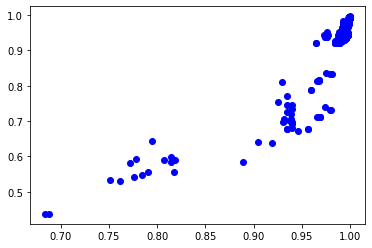

In [30]:
voldata = pd.read_csv('all.csv')
X = np.concatenate((voldata[voldata.columns[1:18]].values[0:8395],voldata[voldata.columns[1:18]].values[8395:]), axis=0)
y = np.concatenate((voldata[voldata.columns[18]].values[0:8395],voldata[voldata.columns[18]].values[8395:]), axis=0)
plt.scatter(vmdata[vmdata.columns[20]], vmdata[vmdata.columns[21]], c='b',label = 'Correct')
plt.show()

In [31]:
X_, y_ = limit_y(X, y, .10)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state = 3)

In [33]:
newy_test = cy(y_test)
newy = cy(y_)
newy_train = cy(y_train)

In [34]:
clf = RandomForestClassifier()
clf.fit(X_train, newy_train)

RandomForestClassifier()

In [35]:
est_y = clf.predict(X_test)
print_stats(est_y, newy_test)

Accuracy: 92.92604501607717

F1 Score: 0.4358974358974359

Percent Anomalies Found: 30.17751479289941


In [36]:
index = []
n = np.shape(X)[1]
for j in range(np.shape(X_test)[0]):
    f = X_test[j,:]
    for i in range(np.shape(X)[0]):
        if sum(X[i,:] == f) == n:
            index.append(i)
dsfn=np.array(index)

In [37]:
def plotcorrect(est_ytest2, newy_test):
    c = 0
    right = []
    wrong = []
    for k in est_ytest2 == newy_test:
        if k == True:
            right.append(dsfn[c])
        else:
            wrong.append(dsfn[c])
        c += 1
        
    plt.figure()
    plt.scatter(voldata[voldata.columns[20]][right], voldata[voldata.columns[21]][right], c='b',label = 'Correct')
    plt.scatter(voldata[voldata.columns[20]][wrong], voldata[voldata.columns[21]][wrong], c='r',label = 'Wrong')
    plt.xlabel(voldata.columns[20])
    plt.ylabel(voldata.columns[21])
    plt.legend()
    plt.show()
    
    fig, axs = plt.subplots(1, 2, sharex=True, sharey = True)
    
    axs[0].hist(voldata[voldata.columns[21]][right])
    axs[1].hist(voldata[voldata.columns[21]][wrong])
    axs[0].set_xlabel('Correct')
    axs[1].set_xlabel('Wrong')
    axs[1].set_yscale('log')
    axs[0].set_yscale('log')
    plt.suptitle('AV per mass ratio')
    plt.show()

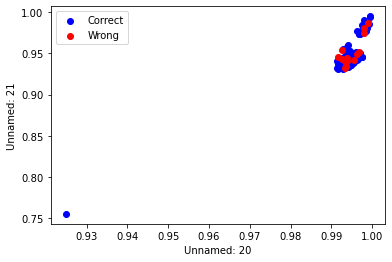

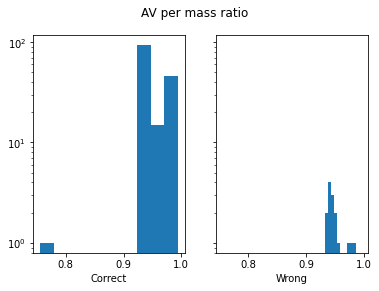

In [38]:
plotcorrect(est_y, newy_test)

In [39]:
m = 100
n_est1 = np.linspace(10, 4000, m)
acc1 = np.zeros(m)
f11 = np.zeros(m)
p_anom1 = np.zeros(m)
rtime1 = np.zeros(m)
prec1 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    model = RandomForestClassifier()
    model.fit(X_train, newy_train)
    est_ytest2 = model.predict(X_test)
    stop = timeit.default_timer()
    
    [acc1, f11, p_anom1, prec1] = calc_stats(acc1, f11, p_anom1, prec1, est_ytest2, newy_test)
    rtime1[i] = stop - start

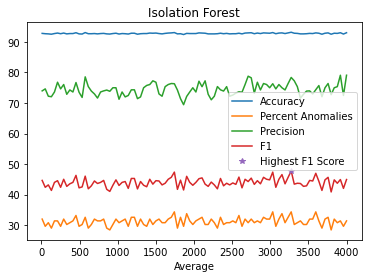

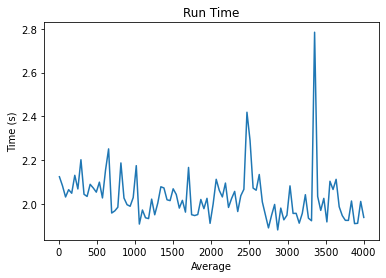

Highest F1 score recorded: 0.47736625514403286
Average F1 score: 0.4394288785224571
Standard Deviation: 0.01453877988754176


In [40]:
plotvar(n_est1, acc1, p_anom1, prec1, f11, rtime1, 'Isolation Forest', 'Average',1)
ind = np.argmax(f11)
print('Highest F1 score recorded:',f11[ind])
print('Average F1 score:',np.mean(f11))
print('Standard Deviation:',np.std(f11))